In [25]:
import pandas as pd
df = pd.read_csv('../datasets/diabetes.csv')
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [27]:
Indexes = []
df_cols = df.columns
for a in df_cols:
    per_75, per_25 = df[a].quantile(0.75), df[a].quantile(0.25)
    iqr = per_75 - per_25
    upperLimit, lowerLimit = per_75 + 1.5 * iqr, per_25 - 1.5 * iqr
    
    i = df.loc[(df[a]>upperLimit) | (df[a]<lowerLimit)].index
    for ele in i:
        if ele not in Indexes:
            Indexes.append(ele)
      
# len(Indexes) # 129
df_clean = df.drop(index=Indexes)
df_clean.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
5,5,116,74,0,0,25.6,0.201,30,0


In [28]:
import numpy as np

df = df_clean

df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)
df.isnull().sum()
#Replace the null values with the median of that column

df['Glucose'].fillna(df['Glucose'].median(), inplace =True)

df['BloodPressure'].fillna(df['BloodPressure'].median(), inplace =True)

df['BMI'].fillna(df['BMI'].median(), inplace =True)

In [29]:

df.isnull().sum()
df.drop("SkinThickness", axis=1, inplace=True)
df.drop("Insulin", axis=1, inplace=True)
df
# SPLIT DF_MALE INTO x & Y
# x = INDEPENDENT VARIABLES
# Y = EPENDENT VARIABLES
y = df['Outcome'].copy()
x = df.drop('Outcome', axis="columns")

y.value_counts()


0    439
1    200
Name: Outcome, dtype: int64

In [30]:
# HANDLE ADTA IMBALANCE - INCREASE/DECREASE ROWS WITH CLASS VALUES(0/1) IF ONE IS LOWER IN NUMBER
# FOR BETTER TRAINING

from imblearn.over_sampling import SMOTE

X_balanced, y_balanced = SMOTE().fit_resample(x, y)
y_balanced.value_counts()


1    439
0    439
Name: Outcome, dtype: int64

In [31]:
# TRAIN-TEST SPLIT
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size=0.8, random_state=42)

# Scale x with a standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
y_train


290    0
685    1
547    1
833    1
770    1
      ..
106    1
270    1
860    1
435    0
102    1
Name: Outcome, Length: 702, dtype: int64

In [32]:
# TRAIN THE MODEL WITH SVM

from sklearn.svm import SVC # "Support vector classifier"  
model = SVC(C=1000, gamma=0.1, kernel='rbf', random_state=42)  
model.fit(x_train, y_train)
model.score(x_test, y_test)


0.8125

In [33]:

# # HYPER PARAMETER TUNING

# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
  
# # defining parameter range
# # param_grid = {'C': [0.1, 1, 10, 100, 1000], 
# #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
# #               'kernel': ['rbf']} 
# param_grid = {
#     'n_estimators':[400],
#     'criterion':["gini", "entropy", "log_loss"],
#     'min_samples_split':[2, 5, 10, 20], 
#     'min_samples_leaf':[1], 
#     'max_features':["sqrt", "log2"], 
#     'max_depth':[30, 50, 70, 100], 
#     'bootstrap':[False], 
#     'random_state':[9],

#     'n_jobs':[4, 10],
# } 
  
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, cv=5, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(x_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
  
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)


In [34]:
# PREDICT RESULTS

y_pred = model.predict(x_test) 
# train_pred = model.predict(x_train)

pred = model.score(x_test, y_test)
print(f"Accuracy : {pred * 100}%")
from sklearn.ensemble import RandomForestClassifier


# rf = RandomForestClassifier(
#     n_estimators=400, 
#     min_samples_split=5, 
#     min_samples_leaf=1, 
#     max_features="sqrt", 
#     max_depth=76, 
#     bootstrap=False, 
#     random_state=9
# )
rf = RandomForestClassifier(
    criterion="entropy",
    bootstrap=False, 
    max_depth=30, 
    # min_samples_split=5,
    n_estimators=400, 
    n_jobs=4, 
    random_state=9
)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)


Accuracy : 81.25%


0.8863636363636364

In [35]:
# PREDICT RESULTS

y_pred = rf.predict(x_test) 
# train_pred = rf.predict(x_train)

pred = rf.score(x_test, y_test)
print(f"Accuracy : {pred * 100}%")


Accuracy : 88.63636363636364%


prediction =>  1
real =>  814    1
Name: Outcome, dtype: int64


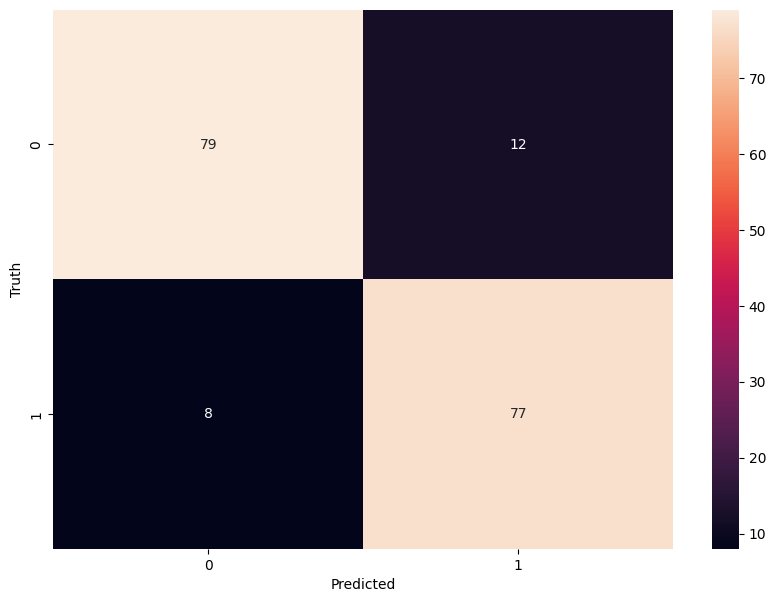

In [36]:
# CONFUSION MATRIX

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix  
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")
# MANUAL CHECKING BY PUTTING ROW VALUES

row = 8
y_pred = rf.predict(x_test.iloc[[row]])
res = y_pred[0]
print('prediction => ', res)
print('real => ', y_test.iloc[[row]])


In [37]:
# # SAVING THE MODEL USING PICKLE PACKAGE

# import pickle

# # save the iris classification model as a pickle file
# model_pkl_file = "../pickles/diabetes-rf.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(rf, file)
# # LOAD AND USE THE SAVED MODEL USING PICKLE PACKAGE
# with open(model_pkl_file, 'rb') as file:  
#     model = pickle.load(file)

# # evaluate model 
# y_pred = model.predict(x_test)

# # check results
# pred = model.score(x_test, y_test)
# print(f"Accuracy : {pred * 100}%")


In [38]:
# HANDLE ADTA IMBALANCE - INCREASE/DECREASE ROWS WITH CLASS VALUES(0/1) IF ONE IS LOWER IN NUMBER
# FOR BETTER TRAINING

from imblearn.over_sampling import SMOTE

X_balanced, y_balanced = SMOTE().fit_resample(x, y)
y_balanced.value_counts()


1    439
0    439
Name: Outcome, dtype: int64

In [39]:
# TRAIN-TEST SPLIT
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_train, x_test, y_train, y_test = train_test_split(X_balanced, y_balanced, train_size=0.8, random_state=42)

# Scale x with a standard scaler
scaler = StandardScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
y_train


290    0
685    1
547    1
833    1
770    1
      ..
106    1
270    1
860    1
435    0
102    1
Name: Outcome, Length: 702, dtype: int64

In [40]:
# TRAIN THE MODEL WITH SVM

from sklearn.svm import SVC # "Support vector classifier"  
model = SVC(C=1000, gamma=0.1, kernel='rbf', random_state=42)  
model.fit(x_train, y_train)


SVC(C=1000, gamma=0.1, random_state=42)

In [41]:
# # HYPER PARAMETER TUNING

# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier
  
# # defining parameter range
# # param_grid = {'C': [0.1, 1, 10, 100, 1000], 
# #               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
# #               'kernel': ['rbf']} 
# param_grid = {
#     'n_estimators':[400],
#     'criterion':["gini", "entropy", "log_loss"],
#     'min_samples_split':[2, 5, 10, 20], 
#     'min_samples_leaf':[1], 
#     'max_features':["sqrt", "log2"], 
#     'max_depth':[30, 50, 70, 100], 
#     'bootstrap':[False], 
#     'random_state':[9],

#     'n_jobs':[4, 10],
# } 
  
# grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, cv=5, verbose = 3)
  
# # fitting the model for grid search
# grid.fit(x_train, y_train)

# # print best parameter after tuning
# print(grid.best_params_)
  


In [42]:
# # print how our model looks after hyper-parameter tuning
# print(grid.best_estimator_)
# PREDICT RESULTS

y_pred = model.predict(x_test) 
# train_pred = model.predict(x_train)

pred = model.score(x_test, y_test)
print(f"Accuracy : {pred * 100}%")
from sklearn.ensemble import RandomForestClassifier


# rf = RandomForestClassifier(
#     n_estimators=400, 
#     min_samples_split=5, 
#     min_samples_leaf=1, 
#     max_features="sqrt", 
#     max_depth=76, 
#     bootstrap=False, 
#     random_state=9
# )
rf = RandomForestClassifier(
    bootstrap=False, 
    max_depth=30, 
    min_samples_split=5,
    n_estimators=400, 
    n_jobs=4, 
    random_state=9
)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)


Accuracy : 79.54545454545455%


0.8181818181818182

Accuracy : 81.81818181818183%


Text(95.72222222222221, 0.5, 'Truth')

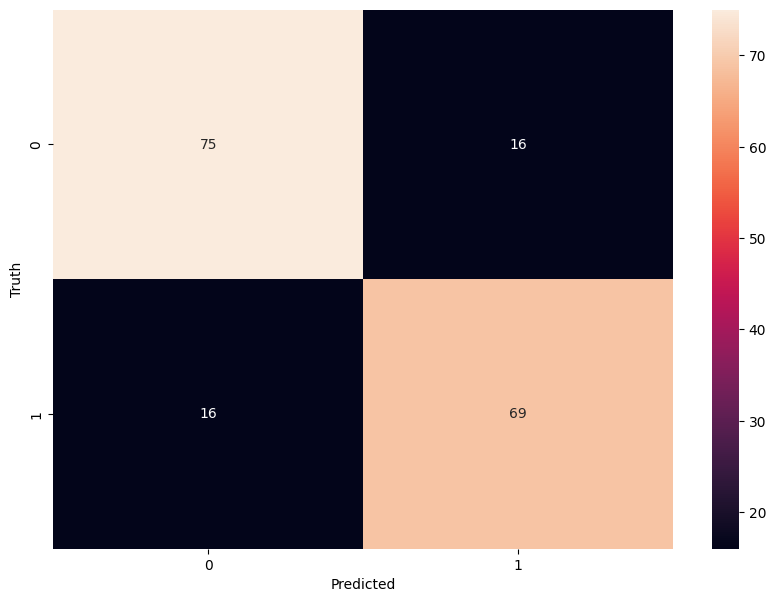

In [43]:
# PREDICT RESULTS

y_pred = rf.predict(x_test) 
# train_pred = rf.predict(x_train)

pred = rf.score(x_test, y_test)
print(f"Accuracy : {pred * 100}%")
# CONFUSION MATRIX

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix  
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Predicted")
plt.ylabel("Truth")


In [44]:
# MANUAL CHECKING BY PUTTING ROW VALUES

row = 8
y_pred = rf.predict(x_test.iloc[[row]])
res = y_pred[0]
print('prediction => ', res)
print('real => ', y_test.iloc[[row]])
# # SAVING THE MODEL USING PICKLE PACKAGE

# import pickle

# # save the iris classification model as a pickle file
# model_pkl_file = "../pickles/diabetes-rf.pkl"  

# with open(model_pkl_file, 'wb') as file:  
#     pickle.dump(rf, file)
# # LOAD AND USE THE SAVED MODEL USING PICKLE PACKAGE
# with open(model_pkl_file, 'rb') as file:  
#     model = pickle.load(file)

# # evaluate model 
# y_pred = model.predict(x_test)

# # check results
# pred = model.score(x_test, y_test)
# print(f"Accuracy : {pred * 100}%")


prediction =>  1
real =>  814    1
Name: Outcome, dtype: int64
